In [226]:
# Import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import mutual_info_classif
import math

# Load data

In [227]:
# Load data
patients_dataset_df = pd.read_excel('Databases/svedem_dataset.xlsx')
print(patients_dataset_df.shape)

(40020, 120)


In [228]:
# Show columns of the datasets (features)
columns=patients_dataset_df.columns.values.tolist()[:]
for i in columns:
    print(i+',',end="")
#patients_dataset_df.head(10)

lopnr,NUMBER_FOLLOWUP,GENDER,D_DEAD,D_DIAGNOSIS_YEAR_BR,RESIDENCY,DIAGNOSIS,CENTRE_TYPE_ID,AGE,SC_FLAG,MMSE_SCORE,FU_FLAG,N_FOLLOWUP,MMSE_occurences,DAYS_DIFF_FU,DAYS_NEXT_FU_MAX_DATE,GLOBAL_ESTIMATE_COGNITION_FU,DODSPL,DAYS_ALIVE_DIAGNOS,alder,Acetylcysteine,Acetylsalicylic acid,Alendronic acid,Alfuzosin,Allopurinol,Amitriptyline,Amlodipine,Apixaban,Artificial tears and other indifferent preparations,Atenolol,Atorvastatin,Bendroflumethiazide,Bisoprolol,Buprenorphine,Calcium, combinations with vitamin D and/or other drugs,Candesartan,Candesartan and diuretics,Carbamide,Citalopram,Clomethiazole,Clopidogrel,Codeine and paracetamol,Colecalciferol,Cyanocobalamin,Dexamethasone,Digoxin,Donepezil,Enalapril,Enalapril and diuretics,Escitalopram,Esomeprazole,Estradiol,Estriol,Felodipine,Ferrous sulfate,Finasteride,Flucloxacillin,Folic acid,Formoterol and budesonide,Furosemide,Gabapentin,Galantamine,Glibenclamide,Glipizide,Glyceryl trinitrate,Hydrochlorothiazide,Hydrochlorothiazide and potassium-

In [229]:
len(patients_dataset_df[patients_dataset_df["N_FOLLOWUP"] < 4])

29698

# Addition/Removing variables

In [230]:
patients_dataset_df['NUMBER_FOLLOWUP'].replace(to_replace = -1, value = 0, inplace=True) # The follow-up number for baseregistrations was represented as "-1". Set it to "0"

In [231]:
# Sort dataframe
patients_dataset_df.sort_values(by = ["lopnr", "NUMBER_FOLLOWUP"], inplace=True, ascending = [True, True])

In [232]:
# Creation of new variables:
#   PREV_MMSE: MMSE score is shifted over time to include on it the future MMSE score. For baseregistration we include past MMSE as 30, as it should be before the dementia,
#   MMSE_DECL: Decline of MMSE with respect the future timepoint
#   DAYS_DIFF_FU_WRT_FU: Difference of days from a registration with respect to the previous registration of that patient
patients_dataset_df['PREV_MMSE'] = patients_dataset_df.groupby('lopnr')['MMSE_SCORE'].shift(1)
patients_dataset_df['PREV_MMSE'] = patients_dataset_df['PREV_MMSE'].fillna(30)
patients_dataset_df['MMSE_DECL'] = -1* (patients_dataset_df['PREV_MMSE'] - patients_dataset_df['MMSE_SCORE'])
patients_dataset_df['DAYS_DIFF_FU_WRT_FU'] = patients_dataset_df['DAYS_DIFF_FU'] - patients_dataset_df.groupby('lopnr')['DAYS_DIFF_FU'].shift(1).fillna(0)

In [233]:
# Variable Definition

#   SveDem variables
static_feat = [ 'GENDER', 'D_DEAD', 'D_DIAGNOSIS_YEAR_BR', 'DAYS_ALIVE_DIAGNOS']
dynamic_feat = ['RESIDENCY', 'DIAGNOSIS', 'CENTRE_TYPE_ID', 'AGE', 'SC_FLAG', 'GLOBAL_ESTIMATE_COGNITION_FU']

#   Drugs
drugs_df = pd.read_excel('Databases/Drugs_codes.xlsx', sheet_name= 4, skiprows = 1)
drug_vars = drugs_df.loc[drugs_df['Percentage wrt database observations'] >= 5, 'Drug name']
drug_vars_aux = drug_vars.tolist()
drug_vars_aux.sort()
drug_vars = pd.Series(drug_vars_aux)
drug_vars_drop = drugs_df.loc[drugs_df['Percentage wrt database observations'] < 5, 'Drug name'] # Filter out drug variables with presence less than 5% along the observations
patients_dataset_df = patients_dataset_df.drop(columns = drug_vars_drop)

In [234]:
drugs_df

,Drug name,ATC code,Counter,Percentage wrt database observations,Total observations
0,Donepezil,N06DA02,12391,30.962019,40020.0
1,Acetylsalicylic acid,B01AC06,11558,28.880560,NaN
2,Cyanocobalamin,B03BA01,10180,25.437281,NaN
3,Simvastatin,C10AA01,7860,19.640180,NaN
4,Paracetamol,N02BE01,7104,17.751124,NaN
...,...,...,...,...,...
95,Carbamide,D02AE01,0,0.000000,NaN
96,Dexamethasone,S01BA01,0,0.000000,NaN
97,Kanyler till insulinpenna,Y92AD00,0,0.000000,NaN
98,Teststickor för glukos,Y92BA00,0,0.000000,NaN


In [235]:
# Binarization of drug variables (They are initially represented by dddd)

for var in drug_vars:
    patients_dataset_df.loc[patients_dataset_df[var]>0,var] = 1
    patients_dataset_df.loc[patients_dataset_df[var]<0,var] = 0

In [236]:
# Fix missing variables
pd.set_option('display.max_columns', None)
#   Diagnosis year is the same for all observations of a patient
patients_dataset_df['D_DIAGNOSIS_YEAR_BR'] = patients_dataset_df.groupby('lopnr')['D_DIAGNOSIS_YEAR_BR'].transform('max')
#   Creating Age at diagnosis variable for all observations
patients_dataset_df.loc[patients_dataset_df['NUMBER_FOLLOWUP'] == 0, 'AGE_BR'] = patients_dataset_df.loc[patients_dataset_df['NUMBER_FOLLOWUP'] == 0, 'AGE'].astype('int')
patients_dataset_df['AGE_BR'].fillna(-1, inplace=True)
patients_dataset_df['AGE_BR'] = patients_dataset_df.groupby('lopnr')['AGE_BR'].transform('max')
#   Fixing missings on the "DIAGNOSIS" variable. If it is missing, it is filled with the previous "DIAGNOSIS" observation of that patient
patients_dataset_df['DIAGNOSIS'] = patients_dataset_df.groupby('lopnr')['DIAGNOSIS'].fillna(method='ffill')
#   Renaming too long variable
patients_dataset_df.rename(columns = {"Calcium, combinations with vitamin D and/or other drugs":"Calcium, VitD and others"}, inplace = True)
drug_vars.replace({"Calcium, combinations with vitamin D and/or other drugs":"Calcium, VitD and others"}, inplace=True)

# Export the dataset

In [238]:
patients_dataset_df_to_excel = patients_dataset_df[['lopnr', 'NUMBER_FOLLOWUP', 'N_FOLLOWUP', 'DAYS_DIFF_FU', 'DAYS_DIFF_FU_WRT_FU', 'MMSE_SCORE', 'MMSE_DECL', 'PREV_MMSE', *static_feat, *dynamic_feat, *drug_vars]]
patients_dataset_df_to_excel.to_excel("Databases/svedem_dataset_processed.xlsx")

# Dataset Characterization

In [239]:
n_FU_max = 3

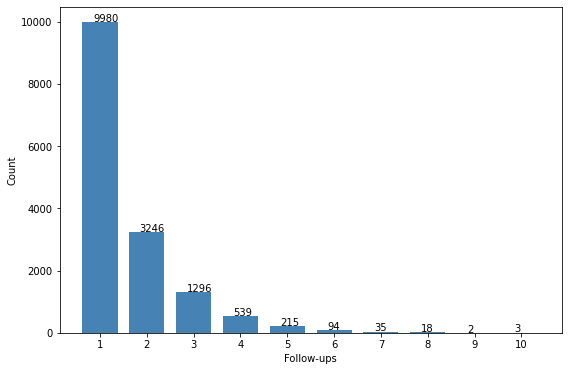

The total number of patients included is: 15428


In [240]:
# Patients with a total number of follow-ups

fig_path = 'Figures - Dataset Statistics/'
NFOLLOWUP_df = patients_dataset_df[patients_dataset_df['FU_FLAG'] == 0][['lopnr','N_FOLLOWUP']]
NFOLLOWUP_count_df = NFOLLOWUP_df.groupby(['N_FOLLOWUP']).count()
x = np.array(NFOLLOWUP_count_df.index)-1
y = NFOLLOWUP_count_df['lopnr'].tolist()
plt.figure(figsize=(9,6))
plt.bar(x, y, width=0.75, color='steelblue')
for i, v in enumerate(y):
    plt.text(x[i]-0.15, v + 25, str(v))
plt.ylabel('Count')
plt.xlabel('Follow-ups')
plt.xticks(x)
plt.savefig(fig_path + 'followups.jpg', dpi=300)
plt.show()

print("The total number of patients included is: {}".format(len(np.unique(patients_dataset_df["lopnr"]))))

In [241]:
patients_dataset_df[patients_dataset_df["NUMBER_FOLLOWUP"]==0][["lopnr", "N_FOLLOWUP"]].groupby('N_FOLLOWUP')['lopnr'].count()# /len(patients_dataset_df[patients_dataset_df["NUMBER_FOLLOWUP"]==0][["lopnr", "N_FOLLOWUP"]])

N_FOLLOWUP
2     9980
3     3246
4     1296
5      539
6      215
7       94
8       35
9       18
10       2
11       3
Name: lopnr, dtype: int64

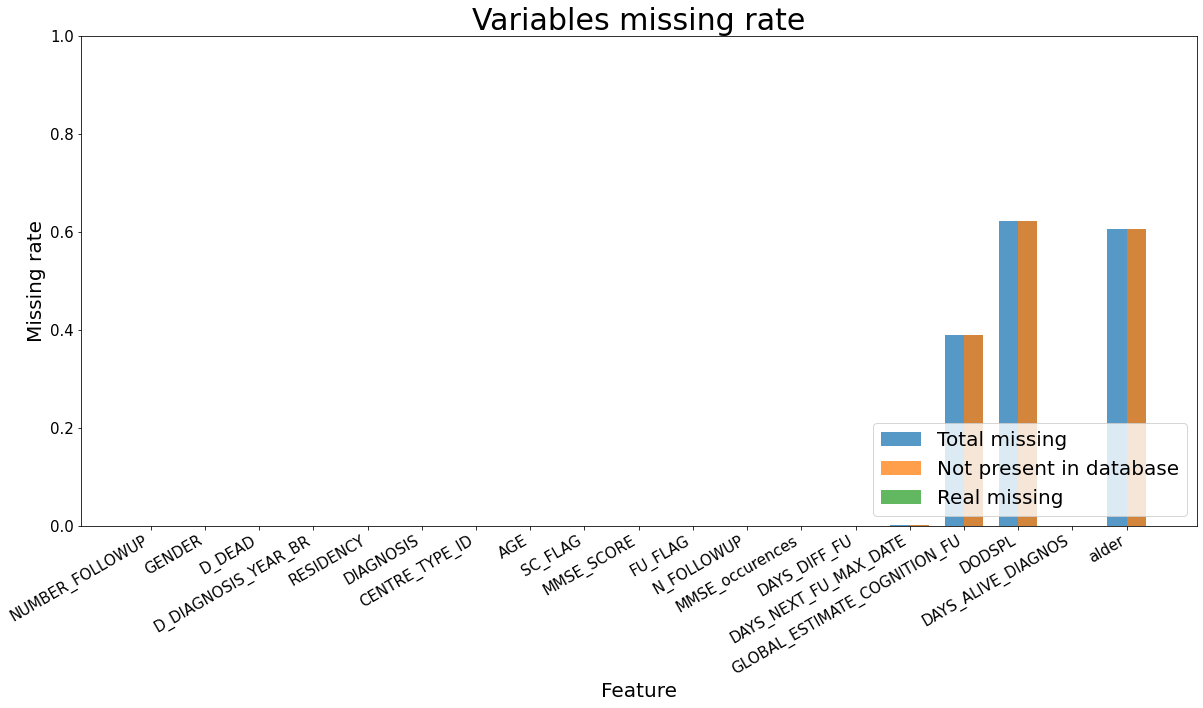

In [242]:
# Variable missing rate

# NAN filling (provisional)
patients_dataset_df = patients_dataset_df.fillna(-1)
    # NAN values caused because of absence in the original dataset are indicated with a "-1". Real NAN values are indicated with a "-2".

missing_count = [0.0] * (len(patients_dataset_df.columns)-1)
missing_ds_count = [0.0] * (len(patients_dataset_df.columns)-1)
missing_count_total = [0.0] * (len(patients_dataset_df.columns)-1)
for index, row in patients_dataset_df.iterrows():
    for i in range(1, len(patients_dataset_df.columns)):
        if (np.isnan(row[i])):
            missing_count[i-1] += 1 
        elif (row[i]==-1):
            missing_ds_count[i-1] += 1
        missing_count_total[i-1] = missing_count[i-1] + missing_ds_count[i-1]
feature_missing_rate = [a/patients_dataset_df.shape[0] for a in missing_count]
feature_missing_ds_rate = [a/patients_dataset_df.shape[0] for a in missing_ds_count]
feature_missing_rate_total = [a/patients_dataset_df.shape[0] for a in missing_count_total]

col_names = patients_dataset_df.columns.values.tolist()[1:]
feature_missing_rate_df = pd.DataFrame(columns = col_names)
feature_missing_rate_df.loc[0] = feature_missing_rate
feature_missing_ds_rate_df = pd.DataFrame(columns = col_names)
feature_missing_ds_rate_df.loc[0] = feature_missing_ds_rate
feature_missing_rate_total_df = pd.DataFrame(columns = col_names)
feature_missing_rate_total_df.loc[0] = feature_missing_rate_total

# Plot
fig = plt.figure(figsize=(20,10))
x = [i for i in range(0,col_names.index(drug_vars[0]))] # We limit since we know that comorbidities and drugs have no missing since we created them 
x = np.linspace(0, col_names.index(drug_vars[0]), col_names.index(drug_vars[0]))
plt.bar(x, feature_missing_rate_total[0:col_names.index(drug_vars[0])], width = 0.75, alpha = 0.75, label='Total missing')
plt.bar(x+0.75/4, feature_missing_ds_rate[0:col_names.index(drug_vars[0])], width = 0.75/2, alpha = 0.75, label='Not present in database')
plt.bar(x-0.75/4, feature_missing_rate[0:col_names.index(drug_vars[0])], width = 0.75/2, alpha = 0.75, label='Real missing')
plt.xlabel('Feature', fontsize =20)
plt.ylabel('Missing rate', fontsize =20)
plt.gca().set_ylim(0,1)
plt.xticks(x, feature_missing_rate_df.columns.values[0:col_names.index(drug_vars[0])], rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right', fontsize=20)
plt.title('Variables missing rate', fontsize=30)
fig.autofmt_xdate()
plt.savefig(fig_path + 'feature_missing_rate.jpg', dpi=300)
plt.show()

In [243]:
patients_dataset_df[patients_dataset_df["NUMBER_FOLLOWUP"] <= 15][drug_vars].sum()/patients_dataset_df[patients_dataset_df["NUMBER_FOLLOWUP"] <= 15][drug_vars].count()*100

Acetylsalicylic acid        28.878061
Amlodipine                   9.865067
Atorvastatin                 6.216892
Calcium, VitD and others    10.152424
Citalopram                  12.811094
Cyanocobalamin              25.437281
Donepezil                   30.962019
Enalapril                   12.583708
Felodipine                   6.476762
Folic acid                  13.435782
Furosemide                   8.573213
Galantamine                 16.321839
Levothyroxine sodium        10.552224
Losartan                     5.352324
Memantine                   17.306347
Metformin                    5.529735
Metoprolol                  15.527236
Mirtazapine                  8.225887
Omeprazole                  10.179910
Oxazepam                     6.674163
Paracetamol                 17.751124
Rivastigmine                11.081959
Sertraline                   5.229885
Simvastatin                 19.640180
Warfarin                     5.464768
Zopiclone                    9.640180
dtype: float

In [244]:
patients_dataset_df[patients_dataset_df["NUMBER_FOLLOWUP"] <= n_FU_max].groupby("NUMBER_FOLLOWUP")[drug_vars].sum()/patients_dataset_df[patients_dataset_df["NUMBER_FOLLOWUP"] <= n_FU_max].groupby("NUMBER_FOLLOWUP")[drug_vars].count()*100

,Acetylsalicylic acid,Amlodipine,Atorvastatin,"Calcium, VitD and others",Citalopram,Cyanocobalamin,Donepezil,Enalapril,Felodipine,Folic acid,Furosemide,Galantamine,Levothyroxine sodium,Losartan,Memantine,Metformin,Metoprolol,Mirtazapine,Omeprazole,Oxazepam,Paracetamol,Rivastigmine,Sertraline,Simvastatin,Warfarin,Zopiclone
NUMBER_FOLLOWUP,,,,,,,,,,,,,,,,,,,,,,,,,,
0,28.461239,9.722582,5.464091,9.605911,11.180970,23.885144,23.003630,12.354161,6.779881,12.159710,7.953072,9.340161,10.480944,4.913145,4.952035,5.399274,15.867254,6.047446,9.327197,5.807623,16.379310,6.105782,4.122375,20.002593,5.885403,9.404978
1,29.841846,10.228157,6.151154,10.720767,13.112523,27.106560,37.023593,12.794918,6.598393,14.194970,9.450350,19.464610,10.908737,5.438164,21.921182,5.490018,16.191340,8.964221,10.461499,7.065076,18.369199,14.376458,5.334457,19.743324,5.477055,10.059632
2,28.524229,9.563142,7.213656,9.911894,14.922907,25.110132,35.205580,12.940529,5.635095,13.986784,8.498532,21.604258,10.609398,5.837004,28.212188,5.763583,14.133627,10.315712,11.196769,7.433921,18.300294,13.913363,6.406021,18.630690,4.662261,9.251101
3,28.746594,9.128065,7.720254,10.535876,15.803815,25.431426,34.695731,11.807448,5.722071,14.759310,7.493188,22.979110,9.673025,6.357856,33.469573,5.949137,13.079019,11.580381,11.307902,7.311535,19.527702,13.533152,7.266122,19.482289,4.450500,9.173479


In [245]:
# Gender cound and percentage per follow-up
for n_FU in range(0, n_FU_max + 1):
    groupby_count = patients_dataset_df[patients_dataset_df['NUMBER_FOLLOWUP']==n_FU].groupby('GENDER')['NUMBER_FOLLOWUP'].count()
    total_count = patients_dataset_df[patients_dataset_df['NUMBER_FOLLOWUP']==n_FU]['NUMBER_FOLLOWUP'].count()
    print("Gender for follow-up {}:\n{}\n{}\n".format(n_FU, groupby_count, groupby_count/total_count*100))

Gender for follow-up 0:
GENDER
1    6112
2    9316
Name: NUMBER_FOLLOWUP, dtype: int64
GENDER
1    39.616282
2    60.383718
Name: NUMBER_FOLLOWUP, dtype: float64

Gender for follow-up 1:
GENDER
1    6112
2    9316
Name: NUMBER_FOLLOWUP, dtype: int64
GENDER
1    39.616282
2    60.383718
Name: NUMBER_FOLLOWUP, dtype: float64

Gender for follow-up 2:
GENDER
1    2293
2    3155
Name: NUMBER_FOLLOWUP, dtype: int64
GENDER
1    42.08884
2    57.91116
Name: NUMBER_FOLLOWUP, dtype: float64

Gender for follow-up 3:
GENDER
1     946
2    1256
Name: NUMBER_FOLLOWUP, dtype: int64
GENDER
1    42.960945
2    57.039055
Name: NUMBER_FOLLOWUP, dtype: float64



In [246]:
# Diagnosis count and percentage per follow-up
for n_FU in range(0, n_FU_max + 1):
    groupby_count = patients_dataset_df[patients_dataset_df['NUMBER_FOLLOWUP']==n_FU].groupby('DIAGNOSIS')['NUMBER_FOLLOWUP'].count()
    total_count = patients_dataset_df[patients_dataset_df['NUMBER_FOLLOWUP']==n_FU]['NUMBER_FOLLOWUP'].count()
    print("diagnosis for follow-up {}:\n{}\n{}\n".format(n_FU, groupby_count, groupby_count/total_count*100))

diagnosis for follow-up 0:
DIAGNOSIS
1.0    1423
2.0    9051
3.0    4954
Name: NUMBER_FOLLOWUP, dtype: int64
DIAGNOSIS
1.0     9.223490
2.0    58.666062
3.0    32.110449
Name: NUMBER_FOLLOWUP, dtype: float64

diagnosis for follow-up 1:
DIAGNOSIS
1.0     1402
2.0     8904
3.0     4949
4.0       34
5.0       32
6.0        6
7.0        4
8.0       51
9.0        5
10.0      41
Name: NUMBER_FOLLOWUP, dtype: int64
DIAGNOSIS
1.0      9.087374
2.0     57.713249
3.0     32.078040
4.0      0.220379
5.0      0.207415
6.0      0.038890
7.0      0.025927
8.0      0.330568
9.0      0.032409
10.0     0.265751
Name: NUMBER_FOLLOWUP, dtype: float64

diagnosis for follow-up 2:
DIAGNOSIS
1.0      723
2.0     3240
3.0     1369
4.0       18
5.0       19
6.0        4
7.0        5
8.0       37
9.0        2
10.0      31
Name: NUMBER_FOLLOWUP, dtype: int64
DIAGNOSIS
1.0     13.270925
2.0     59.471366
3.0     25.128488
4.0      0.330396
5.0      0.348752
6.0      0.073421
7.0      0.091777
8.0      0.679148
9.

In [247]:
# Residency cound and percentage per follow-up
for n_FU in range(0, n_FU_max + 1):
    groupby_count = patients_dataset_df[patients_dataset_df['NUMBER_FOLLOWUP']==n_FU].groupby('RESIDENCY')['NUMBER_FOLLOWUP'].count()
    total_count = patients_dataset_df[patients_dataset_df['NUMBER_FOLLOWUP']==n_FU]['NUMBER_FOLLOWUP'].count()
    print("diagnosis for follow-up {}:\n{}\n{}\n".format(n_FU, groupby_count, groupby_count/total_count*100))

diagnosis for follow-up 0:
RESIDENCY
0    15114
1       98
2      158
3       39
9       19
Name: NUMBER_FOLLOWUP, dtype: int64
RESIDENCY
0    97.964739
1     0.635209
2     1.024112
3     0.252787
9     0.123153
Name: NUMBER_FOLLOWUP, dtype: float64

diagnosis for follow-up 1:
RESIDENCY
0    14415
1      167
2      500
3      319
9       27
Name: NUMBER_FOLLOWUP, dtype: int64
RESIDENCY
0    93.434016
1     1.082447
2     3.240861
3     2.067669
9     0.175006
Name: NUMBER_FOLLOWUP, dtype: float64

diagnosis for follow-up 2:
RESIDENCY
0    5082
1      67
2     146
3     144
9       9
Name: NUMBER_FOLLOWUP, dtype: int64
RESIDENCY
0    93.281938
1     1.229809
2     2.679883
3     2.643172
9     0.165198
Name: NUMBER_FOLLOWUP, dtype: float64

diagnosis for follow-up 3:
RESIDENCY
0    2030
1      29
2      67
3      72
9       4
Name: NUMBER_FOLLOWUP, dtype: int64
RESIDENCY
0    92.188919
1     1.316985
2     3.042688
3     3.269755
9     0.181653
Name: NUMBER_FOLLOWUP, dtype: float64



In [248]:
# Global estimate cognition cound and percentage per follow-up
for n_FU in range(1, n_FU_max + 1):
    groupby_count = patients_dataset_df[patients_dataset_df['NUMBER_FOLLOWUP']==n_FU].groupby('GLOBAL_ESTIMATE_COGNITION_FU')['NUMBER_FOLLOWUP'].count()
    total_count = patients_dataset_df[patients_dataset_df['NUMBER_FOLLOWUP']==n_FU]['NUMBER_FOLLOWUP'].count()
    print("diagnosis for follow-up {}:\n{}\n{}\n".format(n_FU, groupby_count, groupby_count/total_count*100))

diagnosis for follow-up 1:
GLOBAL_ESTIMATE_COGNITION_FU
-1.0      76
 1.0    1884
 2.0    6706
 3.0    6351
 9.0     411
Name: NUMBER_FOLLOWUP, dtype: int64
GLOBAL_ESTIMATE_COGNITION_FU
-1.0     0.492611
 1.0    12.211563
 2.0    43.466425
 3.0    41.165414
 9.0     2.663988
Name: NUMBER_FOLLOWUP, dtype: float64

diagnosis for follow-up 2:
GLOBAL_ESTIMATE_COGNITION_FU
-1.0      39
 1.0     290
 2.0    2091
 3.0    2870
 9.0     158
Name: NUMBER_FOLLOWUP, dtype: int64
GLOBAL_ESTIMATE_COGNITION_FU
-1.0     0.715859
 1.0     5.323054
 2.0    38.381057
 3.0    52.679883
 9.0     2.900147
Name: NUMBER_FOLLOWUP, dtype: float64

diagnosis for follow-up 3:
GLOBAL_ESTIMATE_COGNITION_FU
-1.0      21
 1.0      84
 2.0     848
 3.0    1193
 9.0      56
Name: NUMBER_FOLLOWUP, dtype: int64
GLOBAL_ESTIMATE_COGNITION_FU
-1.0     0.953678
 1.0     3.814714
 2.0    38.510445
 3.0    54.178020
 9.0     2.543143
Name: NUMBER_FOLLOWUP, dtype: float64



In [249]:
vars_list = ['N_FOLLOWUP', 'AGE_BR', 'AGE', 'D_DIAGNOSIS_YEAR_BR', 'DAYS_DIFF_FU', 'DAYS_DIFF_FU_WRT_FU', 'MMSE_SCORE', 'MMSE_DECL']

# Quantitative variables statistics
print("Mean:\n{}\n".format(patients_dataset_df.groupby('NUMBER_FOLLOWUP')[vars_list].mean()))
print("Std:\n{}\n".format(patients_dataset_df.groupby('NUMBER_FOLLOWUP')[vars_list].std()))
print("Median:\n{}\n".format(patients_dataset_df.groupby('NUMBER_FOLLOWUP')[vars_list].median()))

for n_FU in range(n_FU_max, patients_dataset_df['NUMBER_FOLLOWUP'].max()):
    aux = patients_dataset_df[patients_dataset_df['N_FOLLOWUP'] == n_FU].copy()
    print("For patients with {} Follow-up".format(n_FU))
    print("Mean:\n{}\n".format(aux.groupby('NUMBER_FOLLOWUP')[vars_list].mean()))
    print("Std:\n{}\n".format(aux.groupby('NUMBER_FOLLOWUP')[vars_list].std()))
    print("Median:\n{}\n".format(aux.groupby('NUMBER_FOLLOWUP')[vars_list].median()))

Mean:
                 N_FOLLOWUP     AGE_BR        AGE  D_DIAGNOSIS_YEAR_BR  \
NUMBER_FOLLOWUP                                                          
0                  2.593985  77.296344  77.296344          2012.740148   
1                  2.593985  77.296344  78.333679          2012.740148   
2                  3.682085  75.600771  77.800844          2012.236050   
3                  4.687557  74.623524  77.937330          2011.613533   
4                  5.671082  73.849890  78.201987          2011.047461   
5                  6.656676  73.283379  78.632153          2010.553134   
6                  7.585526  72.177632  78.368421          2010.098684   
7                  8.534483  71.448276  78.689655          2009.517241   
8                  9.347826  71.043478  79.347826          2008.478261   
9                 10.600000  71.600000  81.200000          2007.400000   
10                11.000000  74.000000  85.000000          2006.333333   

                 DAYS_DIFF_FU  

In [250]:
%reset